# Optimize Aperture
We want to find the appropriate aperture size to do our photometry, so we will open up one of our files and try different aperture sizes on a single star to see how the counts change with aperture size.  We will pick the aperture in the knee where the new counts start tailing off.

In [14]:
import sys
#myLibPaths = [r'/home/bizard/astronomy/python', r'/home/bizard/astronomy/teaching/ASTR 470 - Obs Astro/2021_Spring/coding' ]
#for libPath in myLibPaths:
 #   if (libPath not in sys.path):
 #       sys.path.insert(0,libPath)

In [15]:
import os
import re
import numpy as np
import re

In [16]:
from matplotlib import pyplot as plt

%matplotlib inline

In [17]:
from astropy import units as u

from astropy.visualization import (
    hist,
    SqrtStretch,
    LogStretch,
    LinearStretch,
    PercentileInterval,
    AsymmetricPercentileInterval,
    MinMaxInterval,
)
from astropy.visualization.mpl_normalize import ImageNormalize
from matplotlib.colors import LogNorm
from astropy.stats import sigma_clipped_stats

from astropy.nddata import CCDData
from astropy.io import fits

In [18]:
from photutils import (
    DAOStarFinder,
    CircularAperture,
    CircularAnnulus
)

# Define Directory Paths

In [19]:
sciencedir = r'./leuschner/reduced/20210304'

ignore_file = re.compile('(median|average|ignore|test|focus)')
bias_pat = re.compile('[bB]ias_[0-9]{1,2}.fits')
dark_pat = re.compile('[dD]ark_([0-9]{1,3})s_[0-9]{1,2}(_debiased.fits|.fits)')
flat_pat = re.compile('[fF]lat_([UBVRIubvri]{1})_[0-9]{1,2}.fits')

# The science files are all of the ones we aren't ignoring *and* 
# aren't one of the calibration files.
#
science_files = [os.path.join(sciencedir,f) for f in os.listdir(sciencedir) if 
                 (f.endswith('.fits') and 
                  (not ignore_file.search(f)) and
                  (not bias_pat.search(f)) and
                  (not dark_pat.search(f)) and
                  (not flat_pat.search(f))
                 ) ]

FileNotFoundError: [Errno 2] No such file or directory: './leuschner/reduced/20210304'

In [21]:
myStar = 'HD16209'
obs_pat = re.compile('{}_([BV]{{1}})_([0-9]{{1,3}})s.fits'.format(myStar))

obs = [o for o in science_files if obs_pat.search(o)]
obs

NameError: name 'science_files' is not defined

# Load in 1 image

In [22]:
ccd = CCDData.read(obs[0],unit='adu')
data = ccd.data
hdr = ccd.header

mean, median, std = sigma_clipped_stats(data,sigma=5.0)
print("Mean: {:.1f}, Median: {:.1f}, Std Dev: {:.1f}".format(mean,median,std))

NameError: name 'obs' is not defined

# Create a background Filter to subtract off gradient
We seem to have a gradient on our first night, use a smoothed gradient to remove it

In [23]:
from photutils import Background2D, MedianBackground, SExtractorBackground
from astropy.stats import SigmaClip

sigma_clip = SigmaClip(sigma=5.)
bkg_estimator = MedianBackground()
bkg = Background2D(data, (50, 50), filter_size=(8, 8),
                       sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)

NameError: name 'data' is not defined

## Find Sources
First, we will find the sources using a guess, then we will pick one of the sources and do our measurements of different aperatures using that source (i.e. vary our fwhm when measuring the flux of that source).  Finally, we should be able to use the optimum fwhm to find our sources in the first place.

In [24]:
fwhm = 12.0 # Need to measure this for average star, seemed to fit out images

In [25]:
daofind = DAOStarFinder(fwhm=fwhm, threshold=5.*std)
sources = daofind(data - bkg.background)  
for col in sources.colnames:  
    sources[col].info.format = '%.8g'  # for consistent table output
print(sources)  

NameError: name 'std' is not defined

## Plot up the identified sources to see how it did

In [26]:
# Make a single array of [x,y] positions rather than two arrays of x and y
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))

# Create circles, centered at each of the positions
apertures = CircularAperture(positions, r=12.)

# Normalize our image using a log stretch, clipping the top 25% of values
norm = ImageNormalize(data - bkg.background,interval=AsymmetricPercentileInterval(90,99), stretch=LogStretch(),clip=True)
# norm = LogNorm()

NameError: name 'sources' is not defined

NameError: name 'data' is not defined

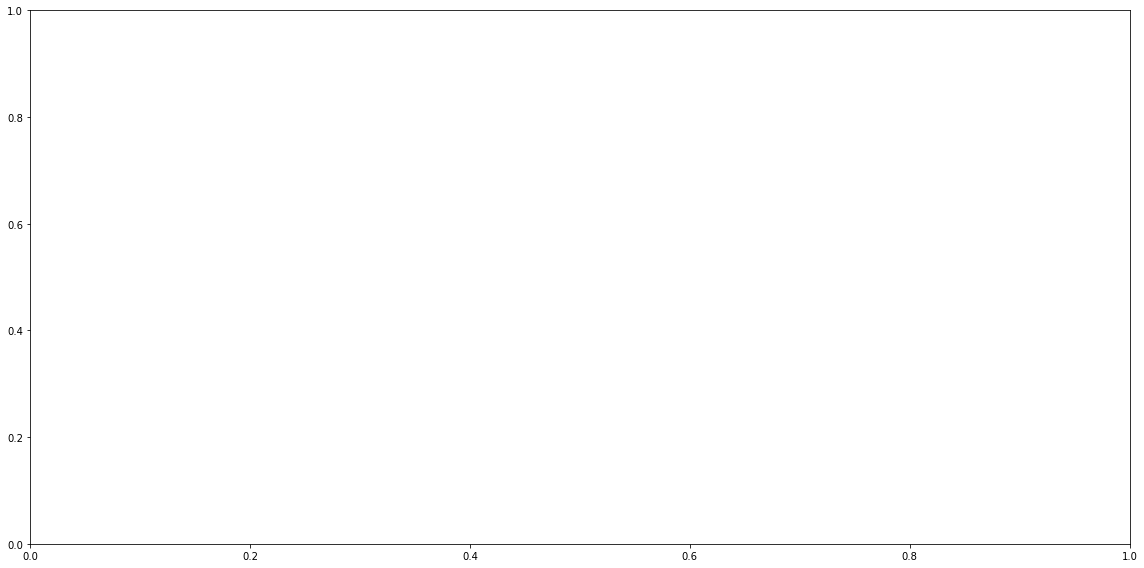

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8), tight_layout=True)

im = ax.imshow(data - bkg.background, cmap='viridis_r', origin='lower', norm=norm, interpolation='nearest')
apertures.plot(color="red", lw=1.5, alpha=0.5)

for i,p in enumerate(positions):
    ax.text(p[0]+8,p[1]+5,i, color="red")

fig.colorbar(im, ax=ax, pad=0.04)

In [ ]:
test_sources = [17,19,23,38]
sources[test_sources]

# 

In [28]:
from photutils import aperture_photometry

In [29]:
rad_range = range(5,40)
ap_sums = {source: [] for source in test_sources}

for idx,r in enumerate(rad_range):
    # Create circles, centered at each of the positions
    aps = CircularAperture(positions[test_sources], r=r)

    phot_table = aperture_photometry(data-bkg.background, aps)
    
    for j,source in enumerate(test_sources):
        ap_sums[source].append(phot_table['aperture_sum'][j])
        
    #for col in phot_table.colnames:
    #    phot_table[col].info.format = '%.8g'  # for consistent table output

NameError: name 'positions' is not defined

In [30]:
print(ap_sums)

{17: [], 19: [], 23: [], 38: []}


ValueError: x and y must have same first dimension, but have shapes (35,) and (0,)

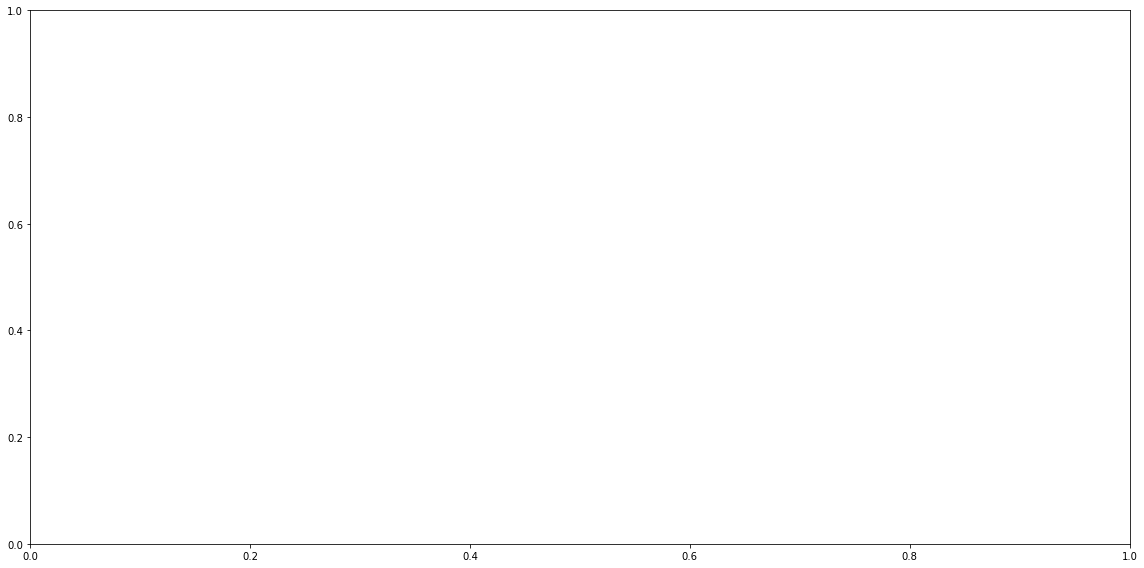

In [31]:
for idx,source in enumerate(test_sources):
    fig, ax = plt.subplots(1, 1, figsize=(16, 8), tight_layout=True)

    ax.plot(np.array(rad_range),ap_sums[source],marker='o')

    ax.axhline(0.95 * np.max(ap_sums[source]), label="95% of max")
    ax.axhline(0.85 * np.max(ap_sums[source]), linestyle="--", label="85% of max")

    ax.set_title("Source {}".format(source+1))
    ax.set_xlabel("Aperture Radius (pixels)")
    ax.set_ylabel("Sum of Counts")
    
    ax.legend()
    
    plt.show()
    
    fig.savefig("plots/sumcounts_{}.png".format(source+1))